In [1]:
import sys
import os
import numpy
import matplotlib.pyplot
import chardet
import json
import importlib
import cModel
importlib.reload(cModel)
import runSolver    
importlib.reload(runSolver)
import propagateErrorLN
importlib.reload(propagateErrorLN)
#you should get nixSuite via git clone https://git0.fmf.uni-lj.si/studen/nixSuite.git"
#if you don't put it to $HOME/software/src/, you should update the path"
#load a solution
def downloadKey(key, doDownload=False):
    fh=os.path.expanduser('~')
    #dummy to get remote
    setupFileSrc=os.path.join(fh,'software','src','PBPK','setup','setupFast.json')
    setup=runSolver.parseSetup(setupFileSrc)
    ref=runSolver.getRunRef(setup,key)
    localDir=os.path.join(fh,'temp',ref)
    setup['localDir']=localDir
    setup['startFromRef']=ref
    if not os.path.isdir(localDir) or doDownload:
        runSolver.loadSolutionFromRef(setup,True)
    return {'localDir':localDir,'ref':ref,'key':key}

def mergeSolutions(solution):
    out={}
    for v in ['t','sol','se','qt','sOut']:
        out[v]=numpy.concatenate([x[v] for x in solution])
    #copy last for settings
    for v in ['lut','lutSE','setup','model','parameters','qt','sOut']:
        out[v]=solution[-1][v]
    #print(solution[0]['sOut'].shape)
    #print(out['sOut'].shape)
    
    #qL=[len(x['t']) for x in sol]
    #print('{} -> {}'.format(qL,len(out['t'])))
    #for k in solution:
    #    print(k.keys())
    return out

def getModel(Q):
    setupFile=Q['setup']
    modelFile=Q['model']
    parameterFile=Q['parameters']
    print('modelFile: {} {}'.format(modelFile,os.path.isfile(modelFile)))
    print('parameterFile: {} {}'.format(parameterFile,os.path.isfile(parameterFile)))
    model=cModel.model()
    model.parse(modelFile,parameterFile)
    return model

def getSum(data,modelName):
    Q=data[modelName]['merged']
    model=getModel(Q)
    lut=Q['lut']
    total=Q['sol'][:,lut['total']]
    #print(total)
    fQ={}
    for x in lut:
        if x=='total':
            continue
        j=lut[x]
        try:
            v=model.get(model.mod['volumes'][x])['value']
            fQ[x]=Q['sol'][:,j]*v/total
        except KeyError:
            #print('{} {}'.format(x,x in model.mod['scaled']))
            fQ[x]=Q['sol'][:,j]
    fSum=numpy.zeros((len(Q['t'])))
    for x in fQ:
        fSum+=fQ[x]
    fQ['sum']=fSum
    return fQ
    #print(sum(list(fQ.values())))
    #print(sorted(fQ.items(), key=lambda item:item[1]))
    
def showTables(Q, hairGrowth=None):
    model=getModel(Q)
    alias={'bloodI':'plasmaI'}
    pars=model.parSetup['parameters']
    vP=model.get('plasmaVolume')['value']
    vV=model.get('venousVolume')['value']
    vRBC=model.get('redBloodCellsVolume')['value']
    print('{} {} {}'.format(vP,vV,vRBC))
    lut=Q['lut']
    fRBC=Q['sol'][:,lut['redBloodCells']]
    fP=Q['sol'][:,lut['plasma']]
    fV=Q['sol'][:,lut['venous']]
    t=Q['t']
    fB=(vV*fV+vP*fP+vRBC*fRBC)/(vV+vP+vRBC)
    #matplotlib.pyplot.plot(t,fV)
    #matplotlib.pyplot.plot(t,fP)
    #matplotlib.pyplot.plot(t,fRBC)
    #matplotlib.pyplot.plot(t,fB)
    #burdens
    table={}
    table['blood']={'burden':fB[-1]*(vV+vP+vRBC)}

    volumes={'liverI':'liverVolume',
             'brainI':'brainVolume',
             'kidneyI':'kidneyVolume'}
    rbdPaper={'blood':5.6,'bloodI':0.02,'liverI':0.4,'brainI':1e-3,'kidneyI':40}

    for v in volumes:
        volumes[v]=model.get(volumes[v])['value']
    
    volumes['bloodI']=(vV+vP+vRBC)
    for x in volumes:
        #print('{} {}'.format(x,volumes[x]))
        try:
            j=int(lut[x])
        except KeyError:
            j=int(lut[alias[x]])
        table[x]={'burden':Q['sol'][-1,j]*volumes[x]}
    
    dose=69.984 #ug/day
    #from internet sources (length of hair + mass of strands + number of strands per head)
    if not hairGrowth:
        hairGrowth=66.7e-6 # 2g/month, 67 mg/day 
        hairGrowth=31.91e-6 # from PC=248.7, kH=7e-3 l/h * power(m,2/3) * 24 h/day * 1 g/l
    
    print('Hair growth {:.2f} mg/day'.format(1e6*hairGrowth))
    print('Daily dose  {:.2f} ug/day'.format(dose))
    
    print()  
    
    
    print('compartment burden(ug)   burden/    burden/dose   ratio')
    print('                       weekly dose      paper    ')
    for x in table:
        r=table[x]
        r['b/d']=r['burden']/dose
        print('{:12} {:8.2f} {:11.2g} {:11.2g} {:9.2f}'.format(x,r['burden'],r['b/d'],rbdPaper[x],r['b/d']/rbdPaper[x]))

    try:
        cBloodI=Q['sol'][-1,lut['plasmaI']]
    except KeyError:
        cBloodI=Q['sol'][-1,lut['bloodI']]
    
    table1={}

    table1['hairMeHg']={}
    v=table1['hairMeHg']
    j=lut['hair']
    v['cH']=Q['sol'][-1,j]*dose/hairGrowth
    v['cB']=fB[-1]
    v['PC']=v['cH']/v['cB']
    v['PCpaper']=291

    table1['hairI']={}
    j=lut['hairI']
    v=table1['hairI']
    v['cH']=Q['sol'][-1,j]*dose/hairGrowth
    v['cB']=cBloodI
    v['PC']=v['cH']/v['cB']
    v['PCpaper']=13164

    table1['hairTotal']={}
    v=table1['hairTotal']
    v['cH']=table1['hairI']['cH']+table1['hairMeHg']['cH']
    v['cB']=table1['hairI']['cB']+table1['hairMeHg']['cB']
    v['PC']=v['cH']/v['cB']
    v['PCpaper']=333

    table1['kidneyI']={}
    v=table1['kidneyI']
    v['cH']=Q['sol'][-1,lut['kidneyI']]
    v['cB']=cBloodI
    v['PC']=v['cH']/v['cB']
    v['PCpaper']=38761

    table1['liverI']={}
    v=table1['liverI']
    v['cH']=Q['sol'][-1,lut['liverI']]
    v['cB']=cBloodI
    v['PC']=v['cH']/v['cB']
    v['PCpaper']=64

    print()
    print('tissue                PC            c[tissue]   c[blood]')
    print('                sim       paper')
    for x in table1:
        r=table1[x]
        print('{:12} {:8.2f} {:11.2f} {:11.2f} {:9.2f}'.format(x,r['PC'],r['PCpaper'],r['cH'],r['cB']))

    #both are portions of ingested dose    
    mMeHg=Q['sol'][-1,lut['hair']]
    mI=Q['sol'][-1,lut['hairI']]
    print()
    print('Hair MeHg {}, I {}      ratio      {}'.format(mMeHg,mI,mMeHg/mI))

In [2]:
data={}
#humanHG=181 #year 5
#data['humanHG']={'ids':[148,171,173,178,181]} #year 1
#data['humanHG_RBC']={'ids':[184,187,188]} #year 1,2 RBC
#humanHG_RBC=187 #year 2 RBC
#humanHGplusI=179 #year 5
#data['humanHGplusI']={'ids':[149,172,175,176,179]} #year 1
#data['humanHGplusI_RBC']={'ids':[185,186,189]} #year 1,2
#data['humanHGplusI_RBCX']={'ids':[185,186,190]} #year 1,2,3
data['humanHGplusI_RBCY']={'ids':[191,192,205]} #year 1,2,3
data['humanHGplusI_RBCZ']={'ids':[207]} #year 1


for x in data:
    data[x]['keys']=[downloadKey(id) for id in data[x]['ids']]
    for d in data[x]['keys']:
        print('Loaded {}'.format(d['localDir']))





loadLibrary
remoteSourcesURL https://git0.fmf.uni-lj.si/studen/nixSuite/raw/master/remoteResources/resources.json
{'labkeyInterface': {'url': 'https://git0.fmf.uni-lj.si/studen/labkeyInterface/archive/master.zip', 'branch': 'master', 'modules': []}, 'irAEMM': {'url': 'https://git0.fmf.uni-lj.si/studen/iraemm/archive/master.zip', 'branch': 'master', 'modules': ['iraemmBrowser']}, 'SlicerLabkeyExtension': {'url': 'https://git0.fmf.uni-lj.si/studen/SlicerLabkeyExtension/archive/SlicerExtensionIndex.zip', 'branch': 'SlicerExtensionIndex', 'modules': ['labkeyBrowser']}, 'limfomiPET': {'url': 'https://git0.fmf.uni-lj.si/studen/limfomiPET/archive/master.zip', 'branch': 'master', 'modules': ['imageBrowser', 'segmentationBrowser']}, 'parseConfig': {'url': 'https://git0.fmf.uni-lj.si/studen/parseConfig/archive/master.zip', 'branch': 'master', 'modules': []}, 'orthancInterface': {'url': 'https://git0.fmf.uni-lj.si/studen/orthancInterface/archive/master.zip', 'branch': 'master', 'modules': []}, 'd

In [3]:
for x in data:
    data[x]['solution']=[runSolver.loadSolutionFromDir(key['localDir'],True) for key in data[x]['keys']]

t0 0 tmax 525600.0
Parsing [1/25]
Parsing [2/25]
Parsing [3/25]
Parsing [4/25]
Parsing [5/25]
Parsing [6/25]
Parsing [7/25]
Parsing [8/25]
Parsing [9/25]
Parsing [10/25]
Parsing [11/25]
Parsing [12/25]
Parsing [13/25]
Parsing [14/25]
Parsing [15/25]
Parsing [16/25]
Parsing [17/25]
Parsing [18/25]
Parsing [19/25]
Parsing [20/25]
Parsing [21/25]
Parsing [22/25]
Parsing [23/25]
Parsing [24/25]
Parsing [25/25]
t0 540000.0 tmax 1051200.0
Parsing [1/24]
Parsing [2/24]
Parsing [3/24]
Parsing [4/24]
Parsing [5/24]
Parsing [6/24]
Parsing [7/24]
Parsing [8/24]
Parsing [9/24]
Parsing [10/24]
Parsing [11/24]
Parsing [12/24]
Parsing [13/24]
Parsing [14/24]
Parsing [15/24]
Parsing [16/24]
Parsing [17/24]
Parsing [18/24]
Parsing [19/24]
Parsing [20/24]
Parsing [21/24]
Parsing [22/24]
Parsing [23/24]
Parsing [24/24]
t0 1058400.0 tmax 1576800.0
Parsing [1/24]
Parsing [2/24]
Parsing [3/24]
Parsing [4/24]
Parsing [5/24]
Parsing [6/24]
Parsing [7/24]
Parsing [8/24]
Parsing [9/24]
Parsing [10/24]
Parsing [

In [4]:
for x in data:
    data[x]['merged']=mergeSolutions(data[x]['solution'])

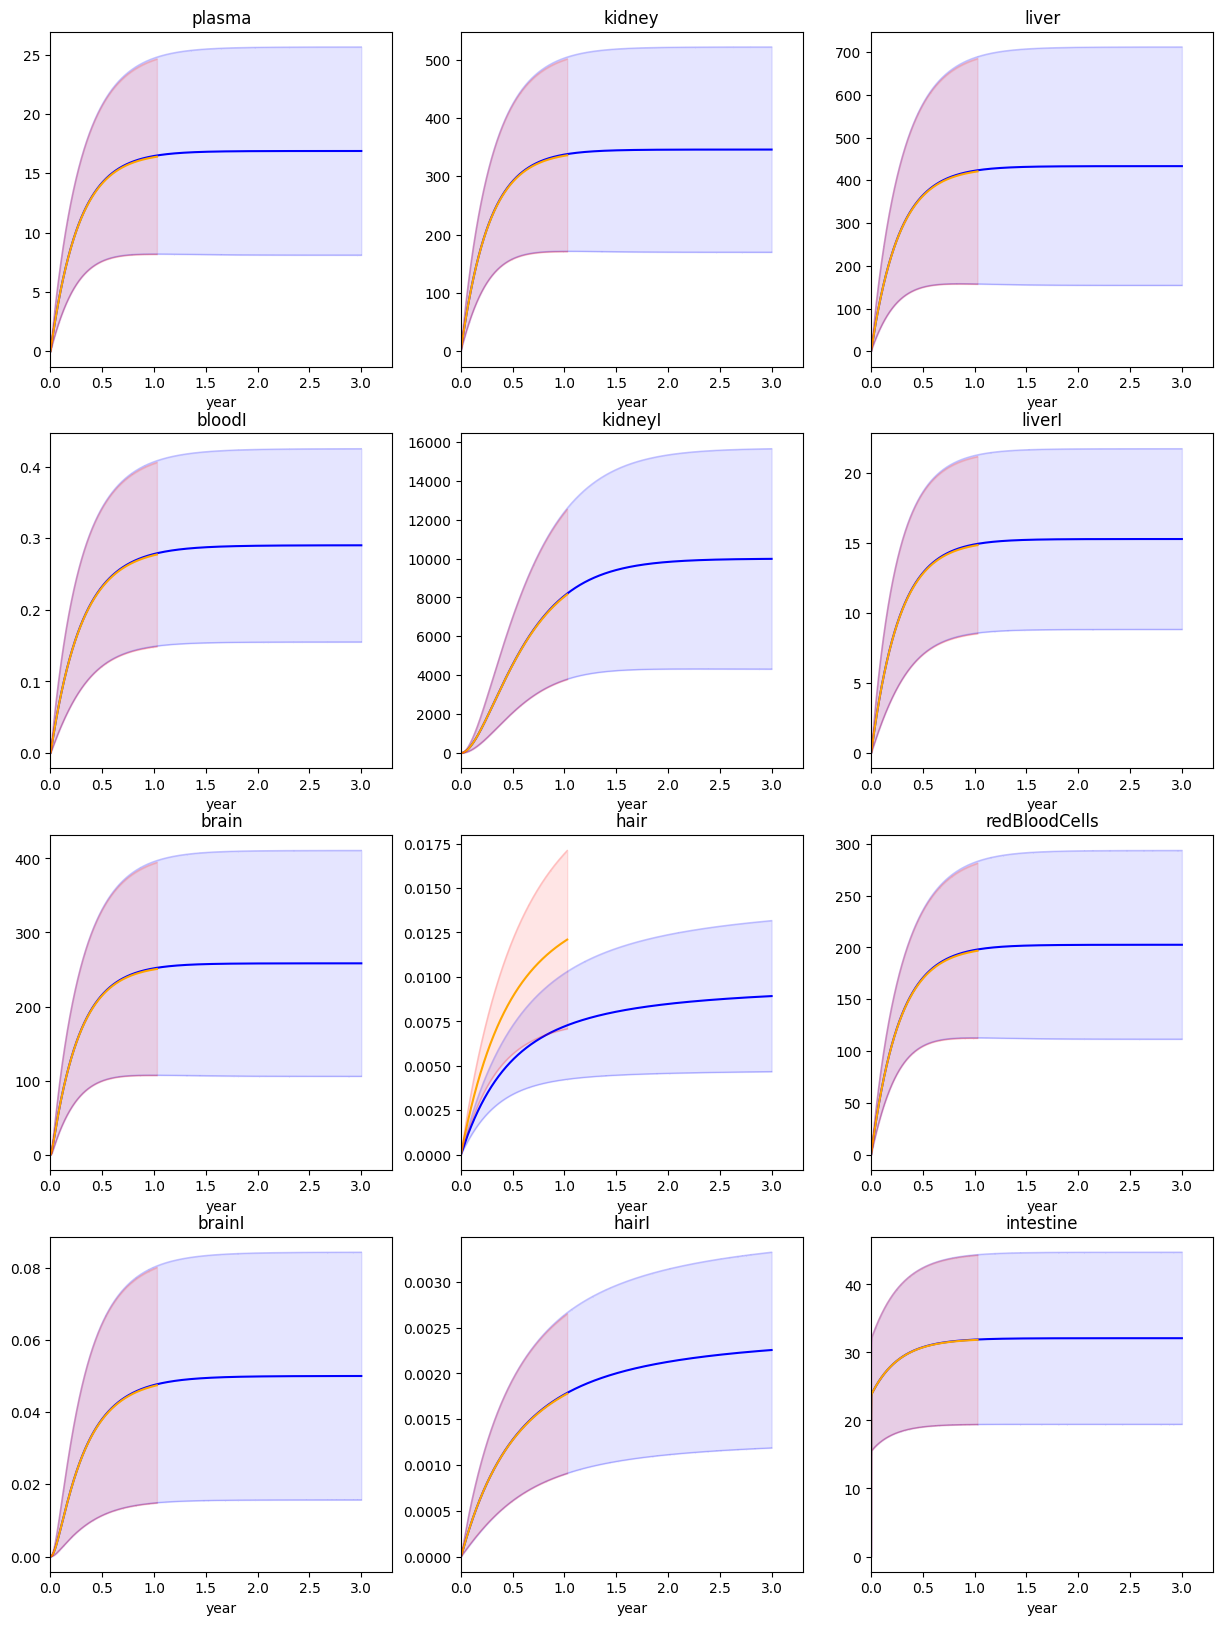

In [5]:
#draws t,,, and t1,,,
x=list(data.keys())[0]
setup=data[x]['merged']['setup']
tscale=runSolver.getScale(setup)
fig, axs = matplotlib.pyplot.subplots(4, 3,figsize=(15,20))
name=['plasma','kidney','liver',
      'bloodI','kidneyI','liverI',
      'brain','hair','redBloodCells',
      #'brainBlood','inorganicMercury','total'
     'brainI','hairI','intestine'
      ]
tmax=numpy.max([data[x]['merged']['t'][-1] for x in data])
max=[-1]*len(name)
#max[2]=2000
models={}
models['humanHGplusI_RBCY']={'color':'blue','shadeColor':'blue'}
#models['humanHG_RBC']={'color':'black','shadeColor':'green'}
models['humanHGplusI_RBCZ']={'color':'orange','shadeColor':'red'}
#models['humanHGplusI_RBC']={'color':'black','shadeColor':'green'}

for i in range(len(name)):
    row=i//3
    col=i%3
    ax=axs[row,col]
    for modelName in models:
        try:
            Q=data[modelName]['merged']
            fy=Q['sol'][:,Q['lut'][name[i]]]
            fe=Q['se'][:,Q['lut'][name[i]]]
            t=Q['t']
            color=models[modelName]['color']
            shadeColor=models[modelName]['shadeColor']
            ax.plot(t/tscale,fy,color=color)
            ax.fill_between(t/tscale, fy-fe, fy + fe, color=shadeColor,alpha=0.1)
            ax.plot(t/tscale,fy-fe,color=shadeColor,linewidth=1,alpha=0.2)
            ax.plot(t/tscale,fy+fe,color=shadeColor,linewidth=1,alpha=0.2)
        except KeyError:
            print('No data for {}'.format(name[i]))
            continue
    if max[i]>0:
        axs[row,col].set_ylim([0,max[i]])
    axs[row,col].set_xlim([0,1.1*tmax/tscale])
    axs[row,col].set_xlabel(setup['tUnit'])
    axs[row,col].set_title(name[i])
    



In [ ]:
volume='hair'
Q=data['humanHGplusI']['solution'][0]
#Q=data['humanHGplusI']['merged']
model=getModel(Q)
pars=model.parSetup['parameters']
lutSE=Q['lutSE']
lut=Q['lut']
y0=Q['sol'][-1][lut[volume]]
dydp=Q['sOut'][-1][lut[volume]]
sigmaAcc=0
cvLN=[]
dydpLN=[]
for p in lutSE:
    par=pars[p]
    try:
        par['dist']
    except KeyError:
        continue
    j=lutSE[p]
    if par['dist']=='normal':
        sigmaAcc+=dydp[j]*dydp[j]
        continue
    cv=par['cv']
    dydpLN.append(dydp[j]/cv)
    cvLN.append(cv)
    print('{:40} {:.2g}/{:.2g}'.format(p,dydp[j],cv))
print('sigmaAcc={}, dydpLN={} cvLN={}'.format(sigmaAcc,dydpLN,cvLN))
fx=numpy.linspace(0,5*y0,101)
cvLN=numpy.array(cvLN)
y=propagateErrorLN.calculateDistribution(fx,y0,numpy.ones(cvLN.shape),cvLN,dydpLN)
#convolve with zero mean gaussian with a sigma=sqrt(sigmaAcc)
fx1=numpy.concatenate((-numpy.flip(fx[1:]),fx))
g=numpy.exp(-0.5*fx1*fx1/sigmaAcc)
y=numpy.concatenate((numpy.zeros((len(fx)-1)),y))
z=numpy.convolve(y,g,'same')
print('{}/{}'.format(len(g),len(y)))
z=z[-len(fx):]


matplotlib.pyplot.plot(fx,z)
matplotlib.pyplot.text(0.5*fx[-1],0.5*numpy.max(z),volume)

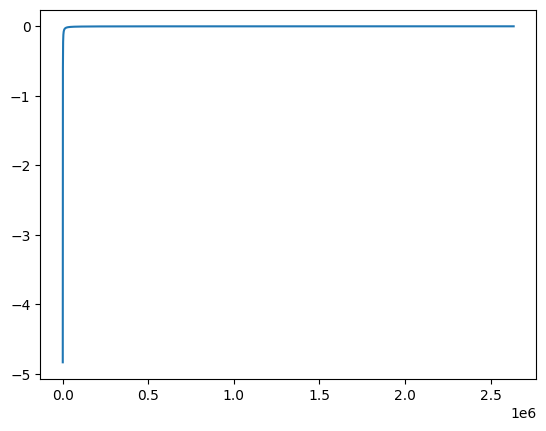

In [76]:
Q=data['humanHGplusI']['merged']
lut=Q['lut']
fy1=Q['sol'][:,lut['redBloodCells']]
fy=Q['sol'][:,lut['plasma']]
qy=fy1[1:]/fy[1:]-12
t=Q['t'][1:]
#matplotlib.pyplot.plot(t[:10],qy[:10])
matplotlib.pyplot.plot(t,qy)

In [13]:
Q=data['humanHGplusI_RBCZ']['merged']
showTables(Q,35e-6)
41.35/24.80


modelFile: /home/studen/temp/1683905089/model.json True
parameterFile: /home/studen/temp/1683905089/parameters.json True
1.3554 1.3554 1.62648
Hair growth 35.00 mg/day
Daily dose  69.98 ug/day

compartment burden(ug)   burden/    burden/dose   ratio
                       weekly dose      paper    
blood          364.50         5.2         5.6      0.93
liverI          26.12        0.37         0.4      0.93
brainI           0.06     0.00092       0.001      0.92
kidneyI       2210.74          32          40      0.79
bloodI           1.20       0.017        0.02      0.86

tissue                PC            c[tissue]   c[blood]
                sim       paper
hairMeHg       287.93      291.00    24197.14     84.04
hairI        12833.88    13164.00     3557.64      0.28
hairTotal      329.17      333.00    27754.78     84.32
kidneyI      29419.61    38761.00     8155.32      0.28
liverI          53.48       64.00       14.83      0.28

Hair MeHg 0.01210133504589178, I 0.00177922649006

1.6673387096774193

modelFile: /home/studen/temp/1677488248/model.json True
parameterFile: /home/studen/temp/1677488248/parameters.json True


/tmp/ipykernel_31670/3547085728.py:69: RuntimeWarning: invalid value encountered in true_divide
  fQ[x]=Q['sol'][:,j]*v/total


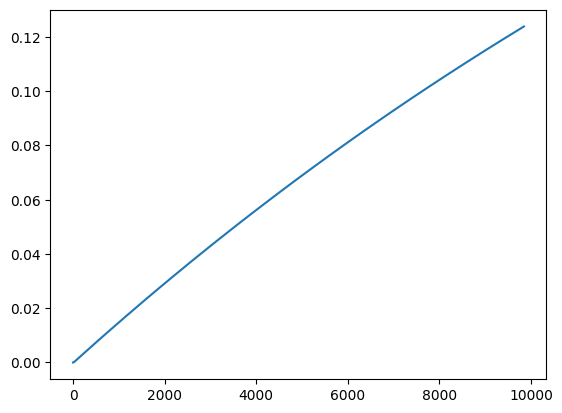

In [194]:
fQ=getSum(data,'humanHGplusI_RBC')
matplotlib.pyplot.plot(fQ['fecesI'][1:])

In [7]:
Q=data['humanHGplusI_RBCY']['merged']
model=getModel(Q)
print('Venous: {}, Plasma: {}, RBC: {}, Blood: {}'.format(
    model.get('venousVolume')['value'],
    model.get('plasmaVolume')['value'],
    model.get('redBloodCellsVolume')['value'],
    model.get('bloodVolume')['value']))
print('Slowly perfused: {}, Richly perfused: {}'.format(
    model.get('slowlyPerfusedVolume')['value'],
    model.get('richlyPerfusedVolume')['value']))
    


modelFile: /home/studen/temp/1678199702/model.json True
parameterFile: /home/studen/temp/1678199702/parameters.json True
Venous: 1.3554, Plasma: 1.3554, RBC: 1.62648, Blood: 4.33728
Slowly perfused: 23.719499999999996, Richly perfused: 6.777
